# Minimizing Tracking Error

In [1]:
# import necessary packages
import numpy as np
import gurobipy as gp
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [17]:
timelimit = 3600 # adjust for last part of optimization

In [3]:
def ret_and_corr(df): 
    # separate index data to its own series and get returns/correlation matrix
    stocks = df.iloc[:,1:]
    stock_ret = stocks.pct_change()[1:]
    index = df.iloc[:,0]
    index_ret = index.pct_change()[1:]
    corrMatrix = stocks.pct_change().iloc[1:].corr()
    
    return stock_ret, index_ret, corrMatrix

## Stock Selection

In [4]:
def stock_select(M, corrMatrix):

    # create objective vector to maximize correlation between fund and index
    N = len(corrMatrix)
    obj = corrMatrix.values.tolist()
    obj = np.array(obj)
    obj = np.concatenate(obj,axis=0)
    obj = np.append(obj,np.zeros(N),axis=0)
    
    # create constraint matrix and vectors
    A = np.zeros((1 + N + N**2,len(obj)))
    b = np.zeros(1 + N + N**2)
    sense = np.array(['']*(1 + N + N**2))

    # constraint to only pick M stocks out of index
    A[0,N*N:] = 1
    b[0] = M
    sense[0] = '='

    # constraint to make sure each stock in index has exactly one representative stock in the fund
    shift = 0
    for i in range(1,N+1):
        for j in range(0,N):
            A[i,j+shift] = 1
        b[i] = 1
        shift += N
        sense[i] = '='

    # constraint guarantees that stock i is best represented by stock j only if j is in the fund.
    row = i+1
    for i in range(0, N):
        for j in range(0, N):
            A[row, i*N+j] = 1
            A[row, N*N+j] = -1
            b[row] = 0
            sense[row] = '<'
            row += 1
    
    # optimize
    trackMod = gp.Model()
    trackMod_x = trackMod.addMVar(len(obj),vtype=['B']*len(obj)) 
    trackMod_con = trackMod.addMConstrs(A, trackMod_x, sense, b)
    trackMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    trackMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    trackMod.optimize()

    # get optimal stocks and return them
    obj_stocks = pd.DataFrame(corrMatrix.reset_index()['index'])
    obj_stocks['obj_x'] = trackMod_x.x[N*N:]
    opt_stocks = list(obj_stocks[obj_stocks['obj_x']==1]['index'])
    
    return opt_stocks

## Portfolio Weights

In [5]:
def stock_weight(df,M):
    # call other functions to get necessary information
    stock_ret, index_ret, corrMatrix = ret_and_corr(df)
    opt_stocks = stock_select(M, corrMatrix)
    
    # get number of days in the index data
    T = len(index_ret)
    stock_ret = stock_ret[opt_stocks]
    
    # create objective vector and constraint matrix
    obj = np.array(np.zeros(M+T))
    obj[M:] = 1
    sense = np.array(['']*(2*T+1))
    b = np.zeros(2*T+1)
    A = np.zeros((2*T+1,len(obj)))

    # constrant to make sure weights sum to 1
    A[0,:M] = 1
    b[0] = 1
    sense[0] = '='

    # constraints for minimizing tracking error with weights and returns
    for i in range(1,T+1):
        A[i,0:M] = stock_ret.iloc[i-1].tolist()
        A[i,M+i-1] = 1
        b[i] = index_ret.iloc[i-1]
        sense[i] = '>'

    for i in range(T+1,T*2+1):
        A[i,0:M] = [-i for i in stock_ret.iloc[i-1-T].tolist()]
        A[i,M+i-1-T] = 1
        b[i] = -(index_ret.iloc[i-1-T])
        sense[i] = '>'
    
    # optimize
    weightMod = gp.Model()
    weightMod_x = weightMod.addMVar(len(obj),vtype=['C']*len(obj)) 
    weightMod_con = weightMod.addMConstrs(A, weightMod_x, sense, b)
    weightMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    weightMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    weightMod.optimize()
    
    # return list of weights
    weights = list(weightMod_x.x[:M])
    
    return weights, opt_stocks

In [10]:
def track_error(df,opt_stocks,weights,M):
    stock_ret, index_ret, corrMatrix = ret_and_corr(df)
    
    # only use optimal stocks chosen to calculate tracking
    opt_stock_ret = stock_ret[opt_stocks]
    fund_ret = pd.DataFrame()
    
    # calculate returns based on calculated weights
    for name,i in zip(opt_stock_ret.columns,range(0,M)):
        fund_ret[f'{name}'] = opt_stock_ret[f'{name}'].apply(lambda x: x * weights[i])
    
    # calculate fund returns
    fund_ret['sum'] = fund_ret.sum(axis=1)
    
    # calculate tracking error between fund and index
    track_err_tot = 0
    for i in range(0,len(index_ret)):
        track_err_tot += abs(index_ret.iloc[i] - fund_ret['sum'].iloc[i])
    return track_err_tot, len(opt_stock_ret.columns)

In [8]:
def track_error_optimal(df,opt_stocks,weights,M):
    stock_ret, index_ret, corrMatrix = ret_and_corr(df)
    
    # calculate number of stocks given
    N = len(stock_ret.columns)
    
    # calcullate return of all stocks based on weights
    fund_ret = pd.DataFrame()
    for name,i in zip(stock_ret.columns,range(0,N)):
        fund_ret[f'{name}'] = stock_ret[f'{name}'].apply(lambda x: x * weights[i])
    
    # only pull optimal stocks into the fund
    fund_ret = fund_ret[opt_stocks]
    
    # calculate fund return
    fund_ret['sum'] = fund_ret.sum(axis=1)
    
    # calculate tracking error between fund and index
    track_err_tot = 0
    for i in range(0,len(index_ret)):
        track_err_tot += abs(index_ret.iloc[i] - fund_ret['sum'].iloc[i])
        
    return track_err_tot, len(fund_ret.columns)

# <font color='red'>Important!
- It is imperative that the data you load in matches the following order:
    - Date in 1st column
    - Index data in 2nd column
    - Index Component Data in the following columns</font>

In [11]:
# read in data, please read above before importing!
df = pd.read_csv('stocks2019.csv',index_col=0)
df2 = pd.read_csv('stocks2020.csv',index_col=0)

# list of how many stocks to include in fund in each iteration
m_list = [5,10,20,30,40,50,60,70,80,90,100]
list_perform = {'m':[], '2019':[], '2020':[]}
df_perform = pd.DataFrame(list_perform)

# use above functions to calculate different fund iterations
for m in m_list:
    weights, opt_stocks = stock_weight(df,m)
    track_err_tot_20, M = track_error(df2,opt_stocks, weights,m)
    track_err_tot_19, M = track_error(df,opt_stocks, weights,m)
    df_perform.loc[len(df_perform)] = [m,track_err_tot_19,track_err_tot_20]
df_perform

,m,2019,2020
0,5.0,0.789178,1.112437
1,10.0,0.686533,1.097709
2,20.0,0.478836,0.899598
3,30.0,0.418015,0.769110
4,40.0,0.367439,0.788335
5,50.0,0.334010,0.773216
6,60.0,0.343788,1.166438
7,70.0,0.168587,0.545744
8,80.0,0.147683,0.537323
9,90.0,0.053779,0.367790


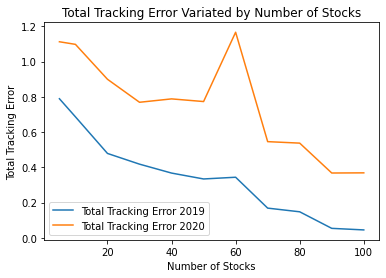

In [12]:
# plot total tracking error vs. number of stocks in fund
plt.plot(df_perform['m'], df_perform['2019'], label = 'Total Tracking Error 2019')
plt.plot(df_perform['m'], df_perform['2020'], label = 'Total Tracking Error 2020')
plt.title('Total Tracking Error Variated by Number of Stocks')
plt.xlabel('Number of Stocks')
plt.ylabel('Total Tracking Error')
plt.legend()
plt.show()

- Clearly, 100 stocks minimizes the tracking error substantially. 5 stocks and 60 stocks seem to maximize the tracking error. There is a total tracking error for both these funds that is over 100%! That is extremely bad if the purpose of the fund was only to passively track the NASDAQ 100. There does not seem to be a place of diminishing returns for an arbitrary M value as the error consistently reduces as more stocks are added.
- Although, there seems to be some disconnect between which stocks are chosen and what weights they will have. This can be fixed by running an optimization problem over both stock selection and weights at the same time, which will be done below.
- The tracking error on 2019 data is much less when compared to 2020 error. This is not surprising as the stocks and weights are determined on 2019 data (i.e., training error vs. test error). The training error will always be lower as that is what the model is fitted on to predict or in this case minimize.

# Weight and Stock Selection

In [13]:
def weight_and_stock(df,m,timelimit):
    stock_ret, index_ret, corrMatrix = ret_and_corr(df)
    
    # calculate number of stocks given
    n = len(stock_ret.columns)
    
    # calculate number of days in index data
    T = len(index_ret)
    
    # initialize objective vector and constraint matrix
    obj = np.array(np.zeros(T+n+n))
    obj[:T] = 1
    A = np.zeros((1+1+T+T+n,len(obj)))
    b = np.array(np.zeros(1+1+T+T+n))
    sense = np.array(['']*(1+1+T+T+n))
    
    # big M constraint to relate weights and chosen stocks together
    M = 1
    
    # constraint 1 to designate how many stocks are in fund
    A[0,T+n:] = 1
    b[0] = m
    sense[0] = '='

    # constraint 2 to make weights sum to 1
    A[1,T:T+n] = 1
    b[1] = 1
    sense[1] = '='

    # constraint 3 to minimize tracking error over all stocks 
    for i in range(2,T+2):
        A[i,T:T+n] = stock_ret.iloc[i-2].tolist()
        A[i,i-2] = 1
        b[i] = index_ret.iloc[i-2]
        sense[i] = '>'

    for i in range(T+2,T*2+2):
        A[i,T:T+n] = [-i for i in stock_ret.iloc[i-2-T].tolist()]
        A[i,i-2-T] = 1
        b[i] = -(index_ret.iloc[i-2-T])
        sense[i] = '>'

    # constraint 4 force weight to be 0 if it is not chosen to be in the fund
    for i in range(T*2+2,T*2+2+n):
        A[i,T+i-T*2-2] = 1
        A[i,T+n+i-T*2-2] = -M
        b[i] = 0
        sense[i] = '<'
    
    # optimize over weights
    weightMod = gp.Model()
    weightMod_x = weightMod.addMVar(len(obj),vtype=['C']*T + ['C']*n + ['B']*n) 
    weightMod_con = weightMod.addMConstrs(A, weightMod_x, sense, b)
    weightMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    weightMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    weightMod.setParam('TimeLimit',timelimit)
    weightMod.optimize()
    
    # get chosen stocks out of objective vector 
    output = weightMod_x.x[T:]
    obj_stocks = pd.DataFrame(corrMatrix.reset_index()['index'])
    obj_stocks['obj_x'] = output[n:]
    opt_stocks = list(obj_stocks[obj_stocks['obj_x']==1]['index'])
    
    # get weights out of objective vector 
    weights = list(output[:n])
    
    return opt_stocks, weights, A,output

# <font color='red'>Important!
- It is imperative that the data you load in matches the following order:
    - Date in 1st column
    - Index data in 2nd column
    - Index Component Data in the following columns</font>

In [18]:
# import data, please read above note first!
df = pd.read_csv('stocks2019.csv',index_col=0)
df2 = pd.read_csv('stocks2020.csv',index_col=0)

# number of stocks in each iteration of the funds
m_list = [5,10,20,30,40,50,60,70,80,90,100]
list_perform = {'m':[], '2019':[], '2020':[]}
df_perform = pd.DataFrame(list_perform)

# use above functions to calculate optimal funds
for m in m_list:
    opt_stocks, weights, A,output = weight_and_stock(df,m,timelimit)
    track_err_tot_20, M = track_error_optimal(df2,opt_stocks, weights,m)
    track_err_tot_19, M = track_error_optimal(df,opt_stocks, weights,m)
    df_perform.loc[len(df_perform)] = [m,track_err_tot_19,track_err_tot_20]
    
# write results to csv file
pd.DataFrame({
    'number of stocks' : df_perform['m'],
    '2019' : df_perform['2019'],
    '2020' : df_perform['2020']
}).to_csv('result.csv', index=False)   
df_perform

,m,2019,2020
0,5.0,0.499259,0.777362
1,10.0,0.301173,0.698325
2,20.0,0.164319,0.552636
3,30.0,0.111827,0.528967
4,40.0,0.081750,0.441826
5,50.0,0.062072,0.375637
6,60.0,0.052614,0.381801
7,70.0,0.047552,0.371814
8,80.0,0.045227,0.370600
9,90.0,0.044911,0.368682


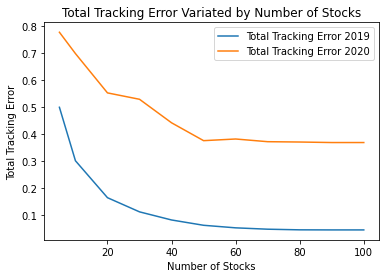

In [19]:
# plot total tracking error vs. number of stocks in each fund
plt.plot(df_perform['m'], df_perform['2019'], label = 'Total Tracking Error 2019')
plt.plot(df_perform['m'], df_perform['2020'], label = 'Total Tracking Error 2020')
plt.title('Total Tracking Error Variated by Number of Stocks')
plt.xlabel('Number of Stocks')
plt.ylabel('Total Tracking Error')
plt.legend()
plt.show()

- This optimization shows a much smoother tracking error. The in-sample error goes almost to 0 for 2019 index data. The out of sample tracking error seems to have diminishing benefits after about 50 stocks. When considering direct and indirect trading costs, there is no reason to have more than 50 stocks in the fund if we plan on passively tracking the index. Although, I would recommend running this optimization problem monthly or quarterly with the last 12 months of data continously as the tracking error for out of sample data is quite high for tracking an index passively. 